#Importing and Unzipping the data

In [1]:
#Importing packages necessary
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('drive/My Drive')

In [4]:
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/4651/35131/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1602413612&Signature=JVAcCIjekEOgp4w8%2FdwOrni4DCyVaisc0soUNioXWqOintIGZYasisT%2FF5kdqxhhQUKi792vrnOFfUp5Y%2FLxdi%2B1z4zN6LpSH%2Bp6JOzrr67AswVuYaDrjHweCPJlZze%2B%2BXBDvuWyY3YHLnw%2BQ0EdAZ%2B%2BrgGxJjqN8csZX3U4itpxYfBr9QBwWPeBJIsZRf3E7TW5ZuZjmQbzJ6w3krmI1OEbHCz%2F%2FMijMqVTTQfYHegVFcVxfdj%2BQtClXm47%2FrydHhB2rF5YZh8dkgyI%2FrTAM8fxPlpK7eb%2BkE31ieBSCEQsNoIdRX5oQhuPVjwx49BQIIMauiiIBDK5VxgcS14iqg%3D%3D&response-content-disposition=attachment%3B+filename%3Dairbnb-recruiting-new-user-bookings.zip" -c -O 'airbnb-recruiting-new-user-bookings.zip'

In [5]:
# !unzip airbnb-recruiting-new-user-bookings.zip

In [6]:
#!unzip age_gender_bkts.csv.zip

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import seaborn as sns
from scipy.sparse import hstack, vstack
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import sklearn
from sklearn.metrics import make_scorer, ndcg_score

#Feature Engineering

We have done the Exploratory Data Analysis on all the datasets given and found a few useful trends and some insights to improve the business.

Now let us do necessary data cleaning and feature engineering to build first cut model. 


To do that, let's have a look at features available from different datasets such that we can think of a way to use them to train our model.

In [ ]:
test = pd.read_csv('test_users.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62096 non-null  object 
 1   date_account_created     62096 non-null  object 
 2   timestamp_first_active   62096 non-null  int64  
 3   date_first_booking       0 non-null      float64
 4   gender                   62096 non-null  object 
 5   age                      33220 non-null  float64
 6   signup_method            62096 non-null  object 
 7   signup_flow              62096 non-null  int64  
 8   language                 62096 non-null  object 
 9   affiliate_channel        62096 non-null  object 
 10  affiliate_provider       62096 non-null  object 
 11  first_affiliate_tracked  62076 non-null  object 
 12  signup_app               62096 non-null  object 
 13  first_device_type        62096 non-null  object 
 14  first_browser         

Age feature has almost 50% null values. We will impute them the same way we impute the missing age values in train data.

Since all the users in test data are new users i.e. who haven't booked yet, date_first_booking has all null values. So, this column in test data is of no use, so we have to drop this column in train data too. Because if we can't use a feature on test data, there is no point in training on it.

In [ ]:
sessions = pd.read_csv('sessions.csv')
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [ ]:
sessions.head(2)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0


Sessions data has actions performed by users and the time (secs) elapsed for that action. From this data, we can create new features like total/mean elapsed time per user, action on which a user spent maximum time, total number of unique device types per user, total number of unique actions performed by a user etc.  

In [ ]:
age_bucket = pd.read_csv('age_gender_bkts.csv')
age_bucket.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


Age bucket data has population stats for each age bucket, each gender, each destination country for year 2015. We need to explore more on how to use this data in train data. 

Countries data set has data about the latitude, longitude, area in square kilometers, language spoken, distance from US, language distance from 'English' of all the destination countries present in our case study.

This won't be of much use for us because data is not user specific.

In [ ]:
train = pd.read_csv('train_users_2.csv')
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [ ]:
train['age'].describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

From above, max value is 2014 and min value is 1 which are clearly outliers. So we need to modify them or remove them. Also from train.info we saw that there are almost half null values. As discussed above, we won't drop this feature but will impute using mean,median or model based. Before that, let us see how many outliers are there

In [ ]:
train[(train['age']>120) | (train['age']<10)]['age']

193          5.0
388       2014.0
482          5.0
642          5.0
660          5.0
           ...  
197386    1938.0
198888    1924.0
206249    1947.0
208819    1949.0
211496    1926.0
Name: age, Length: 838, dtype: float64

As we see, these might be mistakenly entered for year of birth. So we can calculate their age by substracting the year they entered while account creation from year in which the account was created. And we just replace the other values with null values.

In [ ]:
#Replace outliers in age feature with null values
train['age'] = [np.NaN if ((x>120 and x not in range(1900,2000)) or x<10) else x for x in train['age']]
test['age'] = [np.NaN if ((x>120 and x not in range(1900,2000)) or x<10) else x for x in test['age']]
train[(train['age']>120) | (train['age']<10)]['age']

41046     1949.0
55474     1931.0
59537     1932.0
67223     1932.0
67610     1932.0
81999     1928.0
102044    1936.0
104695    1933.0
114377    1935.0
114599    1925.0
118621    1952.0
145422    1927.0
157181    1931.0
157318    1953.0
160781    1942.0
165271    1995.0
180961    1928.0
180995    1924.0
184424    1936.0
189661    1929.0
190142    1949.0
190565    1931.0
194056    1929.0
196558    1947.0
197386    1938.0
198888    1924.0
206249    1947.0
208819    1949.0
211496    1926.0
Name: age, dtype: float64

To calculate the age of the users from above mistakenly given data, we need to know year account created. 

Let us check out date features available viz. date_account_created, timestamp_first_active, date_first_booking. Since we can't use date feature as it is in a model, we can create new feature out of them. For example, we can get day of the week, month from a date. And also, we can calculate time gap between timestamp_first_active and date_account_created etc.

In [ ]:
'''Extract features like weekday, year, month from date features available'''

def extract_weekday(format, datecolumn):
  weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
  day_of_week = [weekdays[datetime.strptime(str(x), format).weekday()] for x in datecolumn]
  return day_of_week

def extract_month(format, datecolumn):
  month = [calendar.month_name[datetime.strptime(str(x), format).month] for x in datecolumn]
  return month

def extract_year(format, datecolumn):
  years = [datetime.strptime(str(x), format).year for x in datecolumn]
  return years

def extract_date(format, datecolumn):
  date = [datetime.strptime(str(x), format).day for x in datecolumn]
  return date

#https://stackoverflow.com/questions/2600775/how-to-get-week-number-in-python
def extract_weeknum(format, datecolumn):
  weeknum = [datetime.strptime(str(x), format).isocalendar()[1] for x in datecolumn]
  return weeknum


In [ ]:
#Create new features in train and test data from date_account_created column
train['day_account_created'] = extract_weekday('%Y-%m-%d', train['date_account_created'])
train['month_account_created'] = extract_month('%Y-%m-%d', train['date_account_created'])
train['year_account_created'] = extract_year('%Y-%m-%d', train['date_account_created'])
train['date__account_created'] = extract_date('%Y-%m-%d', train['date_account_created'])
train['week_account_created'] = extract_weeknum('%Y-%m-%d', train['date_account_created'])

test['day_account_created'] = extract_weekday('%Y-%m-%d', test['date_account_created'])
test['month_account_created'] = extract_month('%Y-%m-%d', test['date_account_created'])
test['year_account_created'] = extract_year('%Y-%m-%d', test['date_account_created'])
test['date__account_created'] = extract_date('%Y-%m-%d', test['date_account_created'])
test['week_account_created'] = extract_weeknum('%Y-%m-%d', test['date_account_created'])

In [ ]:
train.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,day_account_created,month_account_created,year_account_created,date__account_created,week_account_created
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,Monday,June,2010,28,26
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,Wednesday,May,2011,25,21


In [ ]:
train['age'] = [int(train.loc[x]['year_account_created'])-train.loc[x]['age'] if train.loc[x]['age'] in range(1900,2000) else train.loc[x]['age'] for x in train.index]
test['age'] = [int(test.loc[x]['year_account_created'])-test.loc[x]['age'] if test.loc[x]['age'] in range(1900,2000) else test.loc[x]['age'] for x in test.index]

train[(train['age']>120) | (train['age']<10)]['age']

Series([], Name: age, dtype: float64)

In [ ]:
#Create new features in train and test data from timestamp_first_active column
train['day_first_active'] = extract_weekday('%Y%m%d%H%M%S', train['timestamp_first_active'])
train['month_first_active']=extract_month('%Y%m%d%H%M%S', train['timestamp_first_active'])
train['year_first_active']=extract_year('%Y%m%d%H%M%S', train['timestamp_first_active'])
train['date_first_active'] = extract_date('%Y%m%d%H%M%S', train['timestamp_first_active'])
train['week_first_active'] = extract_weeknum('%Y%m%d%H%M%S', train['timestamp_first_active'])

test['day_first_active'] = extract_weekday('%Y%m%d%H%M%S', test['timestamp_first_active'])
test['month_first_active']=extract_month('%Y%m%d%H%M%S', test['timestamp_first_active'])
test['year_first_active']=extract_year('%Y%m%d%H%M%S', test['timestamp_first_active'])
test['date_first_active'] = extract_date('%Y%m%d%H%M%S', test['timestamp_first_active'])
test['week_first_active'] = extract_weeknum('%Y%m%d%H%M%S', test['timestamp_first_active'])
train.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,day_account_created,month_account_created,year_account_created,date__account_created,week_account_created,day_first_active,month_first_active,year_first_active,date_first_active,week_first_active
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,Monday,June,2010,28,26,Thursday,March,2009,19,12
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,Wednesday,May,2011,25,21,Saturday,May,2009,23,21


In [ ]:
def difference_of_days(dac,tfa):

  '''Calculate number of days difference between date first active and date account created feature '''
  
  #Convert them to date format 
  dac_dt = datetime.strptime(str(dac), '%Y-%m-%d')
  tfa_dt = datetime.strptime(str(tfa), '%Y%m%d%H%M%S')
  #Find the difference
  no_of_days = dac_dt-tfa_dt
  return no_of_days.days


In [ ]:
#Create new feature in train and test i.e. number of days between date first active and date account created
train['days_between_tfa_dac'] = train.apply(lambda x: difference_of_days(x.date_account_created,x.timestamp_first_active), axis=1)
test['days_between_tfa_dac'] = test.apply(lambda x: difference_of_days(x.date_account_created,x.timestamp_first_active), axis=1)
train.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,day_account_created,month_account_created,year_account_created,date__account_created,week_account_created,day_first_active,month_first_active,year_first_active,date_first_active,week_first_active,days_between_tfa_dac
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,Monday,June,2010,28,26,Thursday,March,2009,19,12,465
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,Wednesday,May,2011,25,21,Saturday,May,2009,23,21,731


We drop date_first_booking column as mentioned before as test data has all null values for that column (new users).

In [ ]:
train.drop(['date_first_booking'], axis=1, inplace=True)
test.drop(['date_first_booking'], axis=1, inplace=True)

In [ ]:
train.head(2)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,day_account_created,month_account_created,year_account_created,date__account_created,week_account_created,day_first_active,month_first_active,year_first_active,date_first_active,week_first_active,days_between_tfa_dac
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,Monday,June,2010,28,26,Thursday,March,2009,19,12,465
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,Wednesday,May,2011,25,21,Saturday,May,2009,23,21,731


Now let us have a look at age feature.

Null values in age can be treated as null and be imputed using model/mean. Or else if users who are not providing age details have a trend, we should treat it separately by giving unique value to all those users.

We first tried model based imputation. Then I found that users having missing age have an inclination towards NDF more. So we replaced null age with 1 and model performance increased. 

In [ ]:
print(train.age.isnull().sum(),test.age.isnull().sum())
train['age'] = train['age'].fillna(1)
test['age'] = test['age'].fillna(1)
print('After imputing',train.age.isnull().sum(),test.age.isnull().sum())

88799 28885
After imputing 0 0


Similarly for gender feature, there are almost half of users whose gender is unknown. But from the analysis I did, it has been found that users who are not specifying their gender while signing up are not interested in making a booking.

So we leave unknown as a category. Also considering it so gave better results than imputing unknown with model based imputation.

In [ ]:
train['gender'] = train['gender'].astype('str')
test['gender'] = test['gender'].astype('str')

In [ ]:
set(train['gender'])

{'-unknown-', 'FEMALE', 'MALE', 'OTHER'}

Now let us create a new feature if both age and gender are missing or only one of those is missing or none of them is missing.

In [ ]:
#https://stackoverflow.com/questions/10272898/multiple-if-conditions-in-a-python-list-comprehension

train['age_gender_missing'] = [(2 if (x==1 and y=='-unknown-') else (1 if (x==1 or y=='-unknown-') else 0)) for x,y in zip(train['age'],train['gender'])]
train.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,day_account_created,month_account_created,year_account_created,date__account_created,week_account_created,day_first_active,month_first_active,year_first_active,date_first_active,week_first_active,days_between_tfa_dac,age_gender_missing
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,Monday,June,2010,28,26,Thursday,March,2009,19,12,465,2
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,Wednesday,May,2011,25,21,Saturday,May,2009,23,21,731,0
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,Tuesday,September,2010,28,39,Tuesday,June,2009,9,24,475,0
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,Monday,December,2011,5,49,Saturday,October,2009,31,44,764,0
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,Tuesday,September,2010,14,37,Tuesday,December,2009,8,50,279,1


In [ ]:
test['age_gender_missing'] = [(2 if (x==1 and y=='-unknown-') else (1 if (x==1 or y=='-unknown-') else 0)) for x,y in zip(test['age'],test['gender'])]

Let us quickly go through other features. Among other categorical features, first_affiliate_tracked has some null values. So we will impute them with most occuring category (mode).

In [ ]:
#Check number of null values in first_affiliate_tracked feature
train['first_affiliate_tracked'].isnull().sum()

6065

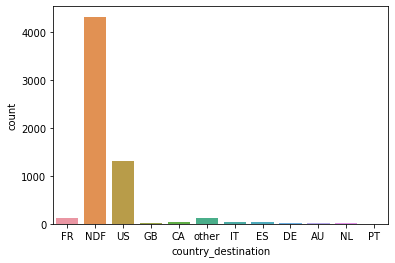

In [ ]:
plot = sns.countplot(x='country_destination',data=train[train['first_affiliate_tracked'].isnull()])

Since there is an inclination towards NDF in users who has first_affiliate_tracked null, we will replace null values with a new category.

To do that we can just convert the feature to string such that 'nan' will be treated as a category

In [ ]:
#Check most occuring first_affiliate_tracked to replace the null values with
train['first_affiliate_tracked'] = train['first_affiliate_tracked'].astype('str')
test['first_affiliate_tracked'] = test['first_affiliate_tracked'].astype('str')
np.unique(train['first_affiliate_tracked'], return_counts=True)

(array(['linked', 'local ops', 'marketing', 'nan', 'omg', 'product',
        'tracked-other', 'untracked'], dtype=object),
 array([ 46287,     34,    139,   6065,  43982,   1556,   6156, 109232]))

In [ ]:
#Since signup_flow is categorical data we convert it to string
train['signup_flow'] = train['signup_flow'].astype('str')
test['signup_flow'] = test['signup_flow'].astype('str')

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import sklearn
from sklearn.metrics import make_scorer, ndcg_score

In [ ]:
train.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination',
       'day_account_created', 'month_account_created', 'year_account_created',
       'date__account_created', 'week_account_created', 'day_first_active',
       'month_first_active', 'year_first_active', 'date_first_active',
       'week_first_active', 'days_between_tfa_dac', 'age_gender_missing'],
      dtype='object')

We will try to create new features using the other given datasets

Lets create features from Sessions data

In [ ]:
sessions.head(2)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0


In [ ]:
def session_features(feature_name, feature_values):

  '''Create features in train and test data using dictionary obtained using grouping of sessions data '''

  #fetch values from dictionary and create new features in train and test data.
  train[feature_name] = [feature_values.get(x,-1) for x in train['id']]
  test[feature_name] = [feature_values.get(x,-1) for x in test['id']]


For 65% of users in train data, there is no data in sessions table. We shall try mean imputation method and then model based method to impute these values. (We can't try median based because median is 0 as more than 50% of values are 0s.


In [ ]:
#Removing outliers. threshold is calculated at the box plot's whisker edge.
threshold = 8444+(1.5*(8444-229))
sessions = sessions[sessions['secs_elapsed']<threshold]

In [ ]:
#create mean elapsed session time per user
mean_elapsed_times = sessions.groupby('user_id')['secs_elapsed'].mean().to_dict()
session_features('mean_session_time',mean_elapsed_times)

In [ ]:
#create total elapsed session time per user
total_elapsed_times = sessions.groupby('user_id')['secs_elapsed'].sum().to_dict()
session_features('total_session_time',total_elapsed_times)

In [ ]:
#create number of sessions performed by a user
sessions_per_user = sessions.groupby('user_id').count()['secs_elapsed'].to_dict()
session_features('sessions_per_user',sessions_per_user)

In [ ]:
#create number of unique device types used by a user
#https://stackoverflow.com/questions/38309729/count-unique-values-with-pandas-per-groups/38309807
unique_devices_per_user = sessions.groupby('user_id')['device_type'].nunique()
session_features('unique_devices_per_user',unique_devices_per_user)

train['unique_devices_per_user'].replace(-1,train['unique_devices_per_user'].mean(), inplace=True)
test['unique_devices_per_user'].replace(-1,test['unique_devices_per_user'].mean(), inplace=True)

In [ ]:
#Changing to string to identify null values
sessions['action_type'] = sessions['action_type'].astype('str')
sessions['action'] = sessions['action'].astype('str')
sessions['action_detail'] = sessions['action_detail'].astype('str')
sessions['device_type'] = sessions['device_type'].astype('str')

In [ ]:
#Most occuring action related features
#https://www.semicolonworld.com/question/53190/groupby-pandas-dataframe-and-select-most-common-value
most_occuring_categories = sessions.groupby(['user_id']).agg(lambda x:x.value_counts().index[0])
most_occuring_categories

,action,action_type,action_detail,device_type,secs_elapsed
user_id,,,,,
00023iyk9l,show,view,p3,Mac Desktop,820.0
0010k6l0om,show,click,nan,Mac Desktop,847.0
001wyh0pz8,search,click,view_search_results,Android App Unknown Phone/Tablet,623.0
0028jgx1x1,show,view,p3,-unknown-,10855.0
002qnbzfs5,show,view,-unknown-,iPhone,1.0
...,...,...,...,...,...
zzxox7jnrx,show,click,nan,Windows Desktop,10781.0
zzy7t0y9cm,header_userpic,data,header_userpic,Windows Desktop,10.0
zzysuoqg6x,header_userpic,-unknown-,-unknown-,Windows Desktop,198.0


In [ ]:
most_occuring_action = most_occuring_categories['action'].to_dict()
most_occuring_action_type = most_occuring_categories['action_type'].to_dict()
most_occuring_action_detail = most_occuring_categories['action_detail'].to_dict()
most_used_device = most_occuring_categories['device_type'].to_dict()

#fetch values from dictionary and create new features in train and test data.
train['most_occuring_action'] = [most_occuring_action.get(x,'nan') for x in train['id']]
test['most_occuring_action'] = [most_occuring_action.get(x,'nan') for x in test['id']]

#fetch values from dictionary and create new features in train and test data.
train['most_occuring_action_type'] = [most_occuring_action_type.get(x,'nan') for x in train['id']]
test['most_occuring_action_type'] = [most_occuring_action_type.get(x,'nan') for x in test['id']]

#fetch values from dictionary and create new features in train and test data.
train['most_occuring_action_detail'] = [most_occuring_action_detail.get(x,'nan') for x in train['id']]
test['most_occuring_action_detail'] = [most_occuring_action_detail.get(x,'nan') for x in test['id']]

#fetch values from dictionary and create new features in train and test data.
train['most_used_device'] = [most_used_device.get(x,'nan') for x in train['id']]
test['most_used_device'] = [most_used_device.get(x,'nan') for x in test['id']]

In [ ]:
#To get action_type and secs_elapsed that has maximum elapsed session time per user 
groups = sessions.groupby('user_id')
vals=[]
for name,group in groups:
  try:
    x = group[group['secs_elapsed']==group['secs_elapsed'].max()][['action_type','action','secs_elapsed']].values
    vals.append((name,x[0][0],x[0][1],x[0][2]))
  except:
    continue
df = pd.DataFrame(vals)
df = df.set_index(0)

train['max_elapsed_action_type'] = [df.loc[x][1] if x in df.index else 'nan' for x in train['id']]
test['max_elapsed_action_type'] = [df.loc[x][1] if x in df.index else 'nan' for x in test['id']]

train['max_elapsed_action'] = [df.loc[x][2] if x in df.index else 'nan' for x in train['id']]
test['max_elapsed_action'] = [df.loc[x][2] if x in df.index else 'nan' for x in test['id']]

train['max_elapsed_time'] = [df.loc[x][3] if x in df.index else -1 for x in train['id']]
test['max_elapsed_time'] = [df.loc[x][3] if x in df.index else -1 for x in test['id']]


In [ ]:
#Take all categorical variables into a list to encode them.
cat_cols = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'day_account_created', 'month_account_created', 'year_account_created',
       'date__account_created', 'week_account_created', 'day_first_active',
       'month_first_active', 'year_first_active', 'date_first_active',
       'week_first_active','age_gender_missing']

In [ ]:
def impute_nulls(feature,feature_type):

  '''Function to impute null values in a feature. 
  We will take the non-null data to train and encode all categorical columns (as age is only numerical and also it has null values)
  and fit the data and predict with data that has null values in train and test data '''
    
  #Separate null valued rows of given feature from train and test  
  if feature_type=='numerical':
    non_null_train = train[train[feature]!=-1]
    null_train = train[train[feature]==-1]
    null_test = test[test[feature]==-1]
    model = DecisionTreeRegressor(max_depth=5)

  if feature_type=='categorical':
    non_null_train = train[train[feature]!='nan']
    null_train = train[train[feature]=='nan']
    null_test = test[test[feature]=='nan']
    model = DecisionTreeClassifier(max_depth=5)

  #Encode categorical features to pass them to imputing model
  encoder = OneHotEncoder(handle_unknown='ignore')
  encoder.fit(non_null_train[cat_cols])
  non_null_train_encoded = encoder.transform(non_null_train[cat_cols]).toarray()
  null_train_encoded = encoder.transform(null_train[cat_cols]).toarray()
  null_test_encoded = encoder.transform(null_test[cat_cols]).toarray()
  
  print(non_null_train_encoded.shape,null_train_encoded.shape, null_test_encoded.shape)

  y_train =  non_null_train[feature]

  model.fit(non_null_train_encoded, y_train)
  imputed_null_train = model.predict(null_train_encoded)
  imputed_null_test = model.predict(null_test_encoded)

  #Replace null values with predictions in train and test data
  train.loc[null_train.index, feature] = imputed_null_train
  test.loc[null_test.index, feature] = imputed_null_test

  print("Null values for ",feature," feature are successfully imputed")


In [ ]:
sessions_numcols = ['mean_session_time','total_session_time','sessions_per_user','max_elapsed_time']
sessions_catcols = ['max_elapsed_action_type','max_elapsed_action','most_occuring_action','most_occuring_action_type','most_occuring_action_detail',
                    'most_used_device']
for col in sessions_catcols:
  impute_nulls(col,'categorical')  
for col in sessions_numcols:
  impute_nulls(col,'numerical')  

(70200, 266) (143251, 266) (3233, 266)
Null values for  max_elapsed_action_type  feature are successfully imputed
(71368, 266) (142083, 266) (1112, 266)
Null values for  max_elapsed_action  feature are successfully imputed
(72094, 266) (141357, 266) (762, 266)
Null values for  most_occuring_action  feature are successfully imputed
(67861, 266) (145590, 266) (4248, 266)
Null values for  most_occuring_action_type  feature are successfully imputed
(61728, 264) (151723, 264) (10793, 264)
Null values for  most_occuring_action_detail  feature are successfully imputed
(72184, 266) (141267, 266) (745, 266)
Null values for  most_used_device  feature are successfully imputed
(72184, 266) (141267, 266) (745, 266)
Null values for  mean_session_time  feature are successfully imputed
(72184, 266) (141267, 266) (745, 266)
Null values for  total_session_time  feature are successfully imputed
(72184, 266) (141267, 266) (745, 266)
Null values for  sessions_per_user  feature are successfully imputed
(721

In [ ]:
!pip install phik

     |████████████████████████████████| 604kB 11.2MB/s 


interval columns not set, guessing: ['age', 'max_elapsed_time', 'unique_devices_per_user', 'year_account_created', 'date__account_created', 'week_account_created', 'year_first_active', 'date_first_active', 'week_first_active', 'age_gender_missing']


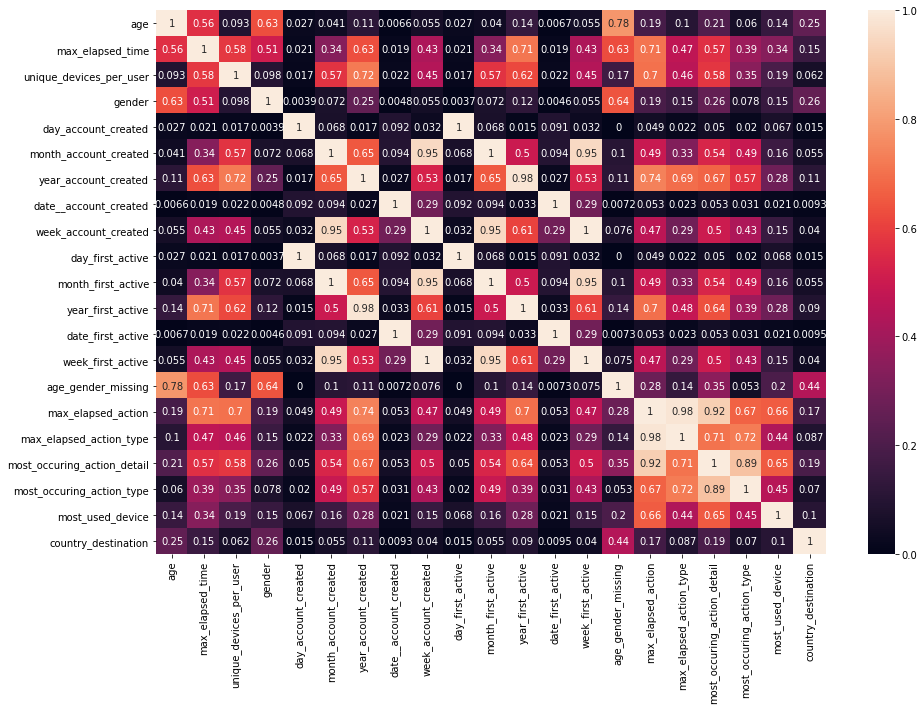

In [ ]:
import phik
numerical_cols = ['age','max_elapsed_time', 'unique_devices_per_user']
cat_cols = ['gender', 'day_account_created', 'month_account_created', 'year_account_created',
       'date__account_created', 'week_account_created', 'day_first_active',
       'month_first_active', 'year_first_active', 'date_first_active',
       'week_first_active','age_gender_missing','max_elapsed_action','max_elapsed_action_type',
       'most_occuring_action_detail','most_occuring_action_type','most_used_device']
train_columns=numerical_cols+cat_cols+['country_destination']
correlation_matrix = train[train_columns].phik_matrix()
plt.figure(figsize=(15,10))
plot = sns.heatmap(correlation_matrix, vmin=0, vmax=1, annot=True)

#Base Model 

In [ ]:
train.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination',
       'day_account_created', 'month_account_created', 'year_account_created',
       'date__account_created', 'week_account_created', 'day_first_active',
       'month_first_active', 'year_first_active', 'date_first_active',
       'week_first_active', 'days_between_tfa_dac', 'age_gender_missing',
       'mean_session_time', 'total_session_time', 'sessions_per_user',
       'unique_devices_per_user', 'most_occuring_action',
       'most_occuring_action_type', 'most_occuring_action_detail',
       'most_used_device', 'max_elapsed_action_type', 'max_elapsed_action',
       'max_elapsed_time'],
      dtype='object')

In [ ]:
#Update numerical and categorical columns to pass them to data preparation
numerical_cols = ['age','days_between_tfa_dac','mean_session_time','total_session_time','sessions_per_user','max_elapsed_time', 'unique_devices_per_user']
cat_cols = ['gender',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser',
       'day_account_created', 'month_account_created', 'year_account_created',
       'date__account_created', 'week_account_created', 'day_first_active',
       'month_first_active', 'year_first_active', 'date_first_active',
       'week_first_active', 'age_gender_missing', 'most_occuring_action',
       'most_occuring_action_type', 'most_occuring_action_detail',
       'most_used_device', 'max_elapsed_action_type', 'max_elapsed_action']

In [13]:
def data_preparation(cat_cols, num_cols):

  '''Function to prepare the data to input to the model.
  For categorical features, we do OneHotEncoding and for numerical we use as is.
  We append both features  '''

  y = train['country_destination']
  X_train, X_test, y_train, y_test = train_test_split(train.drop('country_destination', axis=1),y, test_size=0.2, random_state=42, stratify=y)

  # Label encode the target variable
  le = LabelEncoder()   #Label encoding the target variable since it is multi-class.
  y_train = le.fit_transform(y_train)   
  y_test = le.transform(y_test)

  #Categorical features
  encoder = OneHotEncoder(handle_unknown='ignore') #Onehot encoder, to ignore unknown categories from test data.
  encoder.fit(X_train[cat_cols])   #fitting encoder
  X_train_encoded = encoder.transform(X_train[cat_cols])  #transform X_train, X_test and test features
  X_test_encoded = encoder.transform(X_test[cat_cols])
  test_encoded = encoder.transform(test[cat_cols])

  print("Shapes after encoding categorical features", X_train_encoded.shape, X_test_encoded.shape, test_encoded.shape)

  X_train_numerical_features = np.array(X_train[num_cols])
  X_test_numerical_features = np.array(X_test[num_cols])
  test_numerical_features = np.array(test[num_cols])

  X_train_data = hstack((X_train_encoded, X_train_numerical_features))  #appending categorical encoded and numerical features
  X_test_data = hstack((X_test_encoded, X_test_numerical_features))
  total_test_data = hstack((test_encoded, test_numerical_features))

  print('Shapes of final input data',X_train_data.shape, X_test_data.shape ,total_test_data.shape)
  
  return X_train_data,X_test_data,y_train,y_test,total_test_data, le

def modeltrain(X_train, y_train):

  '''Function to train the model on the prepared train data'''

  model = XGBClassifier(max_depth=5, n_estimators=150, subsample=0.5, colsample_bytree=0.5,objective='multi:softprob', n_jobs=-1,seed=1)  #subsample=0.7, colsample_bytree=0.7, #XGBClassifier with basic parameters.
  # model = XGBClassifier(max_depth=5, n_estimators=150)
  model.fit(X_train, y_train)   #fit the model on train data
  print("Fitted the model with train data...")

  return model

def test_evaluate(X_train, X_test, y_train, y_test, model):

  '''Test the fitted model on X_train and X_test and obtain the ndcg score '''

  #predict on train and test sets with the trained model.
  y_train_pred = model.predict_proba(X_train) 
  y_test_pred = model.predict_proba(X_test)

  #One hot encode the target variable to calculate the ndcg scores 
  ohe = OneHotEncoder()
  y_train_ohe = ohe.fit_transform(y_train.reshape(-1,1))
  y_test_ohe = ohe.transform(y_test.reshape(-1,1))

  ndcg_train = ndcg_score(y_train_ohe.toarray(), y_train_pred)
  ndcg_test = ndcg_score(y_test_ohe.toarray(), y_test_pred)

  print("NDCG scores on train and test data are ",ndcg_train, ndcg_test)

  return model


def predict_for_submission(model, total_test_data, le):

  ''' To generate the submission file by getting the 5 possible predictions from the probability scores obtained from the model'''

  y_pred = model.predict_proba(total_test_data)  #get probabilities on the test data.
  #Taking the 5 classes with highest probabilities
  #Idea to label encode the target variable to get labels using inverse_transform is taken from https://www.kaggle.com/zhugds/test-script
  #https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order arg_sort in descending order.

  predictions = np.array([le.inverse_transform((-1*x).argsort()[:5]) for x in y_pred]).flatten()
  test_ids = np.array([[x]*5 for x in test['id']]).flatten()
  submission = pd.DataFrame(np.stack((test_ids, predictions), axis=1), columns=['id','country'])
  submission.to_csv('submission.csv', index=False)
  print("Successfully first 5 predictions are generated for test users.")
  

In [ ]:
#Prepare the data, train it and predict
X_train, X_test, y_train, y_test, test_data, le = data_preparation(cat_cols, numerical_cols)
model = modeltrain(X_train, y_train)
model = test_evaluate(X_train, X_test, y_train, y_test, model)


Shapes after encoding categorical features (170760, 857) (42691, 857) (62096, 857)
Shapes of final input data (170760, 864) (42691, 864) (62096, 864)
Fitted the model with train data...
NDCG scores on train and test data are  0.8466472533826033 0.84254771364806


In [ ]:
predict_for_submission(model, test_data, le)

Successfully first 5 predictions are generated for test users.


In [ ]:
# import pickle
# out = open('CS1data_upd.pkl', 'wb')
# pickle.dump((X_train, X_test, y_train, y_test, test_data, le), out)
# out.close

<function BufferedWriter.close>

In [8]:
import pickle
infile = open('CS1data_upd.pkl', 'rb')
X_train, X_test, y_train, y_test, test_data, le = pickle.load(infile)
infile.close()

In [22]:
#Hyper parameter tuning on XGB model


clf = XGBClassifier()

params = {
          'n_estimators' : [50,100,150],
          'max_depth' : [3,5,7],
          'learning_rate' : [0.01,0.1,1],
          'subsample':[0.5,0.75,1], 
          'colsample_bytree':[0.5,0.75,1]
          }

grid = RandomizedSearchCV(estimator=clf, 
                    verbose=10, n_iter=10,
                    param_distributions=params, 
                    cv=2,
                    refit=True)
                    # scoring=make_scorer(ndcg_score))

grid.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] subsample=0.75, n_estimators=150, max_depth=5, learning_rate=0.1, colsample_bytree=0.75 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.75, n_estimators=150, max_depth=5, learning_rate=0.1, colsample_bytree=0.75, score=0.645, total= 4.3min
[CV] subsample=0.75, n_estimators=150, max_depth=5, learning_rate=0.1, colsample_bytree=0.75 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[CV]  subsample=0.75, n_estimators=150, max_depth=5, learning_rate=0.1, colsample_bytree=0.75, score=0.645, total= 4.3min
[CV] subsample=0.75, n_estimators=150, max_depth=7, learning_rate=1, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.5min remaining:    0.0s


[CV]  subsample=0.75, n_estimators=150, max_depth=7, learning_rate=1, colsample_bytree=1, score=0.570, total= 7.5min
[CV] subsample=0.75, n_estimators=150, max_depth=7, learning_rate=1, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 16.0min remaining:    0.0s


[CV]  subsample=0.75, n_estimators=150, max_depth=7, learning_rate=1, colsample_bytree=1, score=0.600, total= 7.3min
[CV] subsample=0.75, n_estimators=100, max_depth=5, learning_rate=1, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 23.3min remaining:    0.0s


[CV]  subsample=0.75, n_estimators=100, max_depth=5, learning_rate=1, colsample_bytree=1, score=0.624, total= 3.5min
[CV] subsample=0.75, n_estimators=100, max_depth=5, learning_rate=1, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 26.8min remaining:    0.0s


[CV]  subsample=0.75, n_estimators=100, max_depth=5, learning_rate=1, colsample_bytree=1, score=0.625, total= 3.5min
[CV] subsample=0.5, n_estimators=150, max_depth=3, learning_rate=0.1, colsample_bytree=0.75 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 30.2min remaining:    0.0s


[CV]  subsample=0.5, n_estimators=150, max_depth=3, learning_rate=0.1, colsample_bytree=0.75, score=0.644, total= 3.1min
[CV] subsample=0.5, n_estimators=150, max_depth=3, learning_rate=0.1, colsample_bytree=0.75 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 33.3min remaining:    0.0s


[CV]  subsample=0.5, n_estimators=150, max_depth=3, learning_rate=0.1, colsample_bytree=0.75, score=0.644, total= 3.1min
[CV] subsample=0.75, n_estimators=150, max_depth=3, learning_rate=0.1, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 36.4min remaining:    0.0s


[CV]  subsample=0.75, n_estimators=150, max_depth=3, learning_rate=0.1, colsample_bytree=1, score=0.644, total= 3.3min
[CV] subsample=0.75, n_estimators=150, max_depth=3, learning_rate=0.1, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 39.7min remaining:    0.0s


[CV]  subsample=0.75, n_estimators=150, max_depth=3, learning_rate=0.1, colsample_bytree=1, score=0.644, total= 3.3min
[CV] subsample=0.5, n_estimators=100, max_depth=3, learning_rate=1, colsample_bytree=1 
[CV]  subsample=0.5, n_estimators=100, max_depth=3, learning_rate=1, colsample_bytree=1, score=0.632, total= 2.5min
[CV] subsample=0.5, n_estimators=100, max_depth=3, learning_rate=1, colsample_bytree=1 
[CV]  subsample=0.5, n_estimators=100, max_depth=3, learning_rate=1, colsample_bytree=1, score=0.635, total= 2.5min
[CV] subsample=1, n_estimators=150, max_depth=3, learning_rate=1, colsample_bytree=0.75 
[CV]  subsample=1, n_estimators=150, max_depth=3, learning_rate=1, colsample_bytree=0.75, score=0.571, total= 1.5min
[CV] subsample=1, n_estimators=150, max_depth=3, learning_rate=1, colsample_bytree=0.75 
[CV]  subsample=1, n_estimators=150, max_depth=3, learning_rate=1, colsample_bytree=0.75, score=0.641, total= 2.3min
[CV] subsample=0.75, n_estimators=100, max_depth=3, learning_

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 67.8min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...ght=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated

On submitting the test predictions in Kaggle with the First cut approach, public leaderboard score 0.86307 is achieved.

And with current features and models with XGB model alone, public score is 0.87123 and private score is 0.87629.

After doing the hyper parameter tuning for XGB, public score of 0.87245 and private score of 0.87674 is achieved. This is a slight improvement.

#StackingCVClassifier-MLXTEND

In [26]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [ ]:
#As suggested we are sampling the data to do hyper parameter tuning as it will take very long time otherwise
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_train,y_train, test_size=0.5, random_state=42, stratify=y_train)
X_train_sampled.shape

(85380, 614)

In [ ]:
# Initializing models

clf1 = DecisionTreeClassifier()
clf2 = XGBClassifier()
clf3 = LogisticRegression()
clf4 = GaussianNB()
clf5 = KNeighborsClassifier()
models = [clf1, clf2, clf3, clf4, clf5]

lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=models, 
                            meta_classifier=lr,cv=2,
                            use_probas=True)

#'kneighborsclassifier__n_neighbors': [3, 5, 7],
params = {'decisiontreeclassifier__max_depth': [3, 5, 7],
          'xgbclassifier__n_estimators' : [50,100,150],
          'xgbclassifier__max_depth' : [3,5,7],
          'xgbclassifier__learning_rate' : [0.01,0.1,1],
          'logisticregression__C': [0.01,0.1, 1,10],
          'kneighborsclassifier__n_neighbors': [3, 5, 7],
          'meta_classifier__C': [0.1,1,10]}

grid = RandomizedSearchCV(estimator=sclf, 
                    verbose=10, n_iter=10,
                    param_distributions=params, 
                    cv=2,
                    refit=True)
# scoring=make_scorer(ndcg_score))

grid.fit(X_train_sampled.toarray(), y_train_sampled)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.01, meta_classifier__C=1, logisticregression__C=1, kneighborsclassifier__n_neighbors=3, decisiontreeclassifier__max_depth=7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.01, meta_classifier__C=1, logisticregression__C=1, kneighborsclassifier__n_neighbors=3, decisiontreeclassifier__max_depth=7, score=0.640, total=33.8min
[CV] xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.01, meta_classifier__C=1, logisticregression__C=1, kneighborsclassifier__n_neighbors=3, decisiontreeclassifier__max_depth=7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 33.8min remaining:    0.0s


[CV]  xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.01, meta_classifier__C=1, logisticregression__C=1, kneighborsclassifier__n_neighbors=3, decisiontreeclassifier__max_depth=7, score=0.638, total=33.7min
[CV] xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.1, meta_classifier__C=0.1, logisticregression__C=0.1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 67.5min remaining:    0.0s


[CV]  xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.1, meta_classifier__C=0.1, logisticregression__C=0.1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=5, score=0.644, total=34.3min
[CV] xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.1, meta_classifier__C=0.1, logisticregression__C=0.1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 101.8min remaining:    0.0s


[CV]  xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.1, meta_classifier__C=0.1, logisticregression__C=0.1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=5, score=0.643, total=34.1min
[CV] xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.01, meta_classifier__C=10, logisticregression__C=1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=3 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 135.9min remaining:    0.0s


[CV]  xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.01, meta_classifier__C=10, logisticregression__C=1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=3, score=0.641, total=33.6min
[CV] xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.01, meta_classifier__C=10, logisticregression__C=1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=3 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 169.5min remaining:    0.0s


[CV]  xgbclassifier__n_estimators=150, xgbclassifier__max_depth=3, xgbclassifier__learning_rate=0.01, meta_classifier__C=10, logisticregression__C=1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=3, score=0.638, total=33.7min
[CV] xgbclassifier__n_estimators=100, xgbclassifier__max_depth=5, xgbclassifier__learning_rate=1, meta_classifier__C=0.1, logisticregression__C=0.1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=5 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 203.2min remaining:    0.0s


[CV]  xgbclassifier__n_estimators=100, xgbclassifier__max_depth=5, xgbclassifier__learning_rate=1, meta_classifier__C=0.1, logisticregression__C=0.1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=5, score=0.639, total=36.1min
[CV] xgbclassifier__n_estimators=100, xgbclassifier__max_depth=5, xgbclassifier__learning_rate=1, meta_classifier__C=0.1, logisticregression__C=0.1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=5 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 239.3min remaining:    0.0s


[CV]  xgbclassifier__n_estimators=100, xgbclassifier__max_depth=5, xgbclassifier__learning_rate=1, meta_classifier__C=0.1, logisticregression__C=0.1, kneighborsclassifier__n_neighbors=7, decisiontreeclassifier__max_depth=5, score=0.636, total=35.3min
[CV] xgbclassifier__n_estimators=50, xgbclassifier__max_depth=5, xgbclassifier__learning_rate=1, meta_classifier__C=1, logisticregression__C=0.01, kneighborsclassifier__n_neighbors=5, decisiontreeclassifier__max_depth=5 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 274.6min remaining:    0.0s


[CV]  xgbclassifier__n_estimators=50, xgbclassifier__max_depth=5, xgbclassifier__learning_rate=1, meta_classifier__C=1, logisticregression__C=0.01, kneighborsclassifier__n_neighbors=5, decisiontreeclassifier__max_depth=5, score=0.638, total=20.2min
[CV] xgbclassifier__n_estimators=50, xgbclassifier__max_depth=5, xgbclassifier__learning_rate=1, meta_classifier__C=1, logisticregression__C=0.01, kneighborsclassifier__n_neighbors=5, decisiontreeclassifier__max_depth=5 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 294.8min remaining:    0.0s


[CV]  xgbclassifier__n_estimators=50, xgbclassifier__max_depth=5, xgbclassifier__learning_rate=1, meta_classifier__C=1, logisticregression__C=0.01, kneighborsclassifier__n_neighbors=5, decisiontreeclassifier__max_depth=5, score=0.636, total=20.1min
[CV] xgbclassifier__n_estimators=100, xgbclassifier__max_depth=7, xgbclassifier__learning_rate=0.01, meta_classifier__C=0.1, logisticregression__C=0.01, kneighborsclassifier__n_neighbors=5, decisiontreeclassifier__max_depth=3 
[CV]  xgbclassifier__n_estimators=100, xgbclassifier__max_depth=7, xgbclassifier__learning_rate=0.01, meta_classifier__C=0.1, logisticregression__C=0.01, kneighborsclassifier__n_neighbors=5, decisiontreeclassifier__max_depth=3, score=0.642, total=44.8min
[CV] xgbclassifier__n_estimators=100, xgbclassifier__max_depth=7, xgbclassifier__learning_rate=0.01, meta_classifier__C=0.1, logisticregression__C=0.01, kneighborsclassifier__n_neighbors=5, decisiontreeclassifier__max_depth=3 
[CV]  xgbclassifier__n_estimators=100, xgb

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 641.1min finished


In [27]:
clf1 = DecisionTreeClassifier(max_depth=5)
clf2 = XGBClassifier(n_estimators=100,max_depth=5)
clf3 = LogisticRegression()
clf4 = GaussianNB()
clf5 = KNeighborsClassifier(n_neighbors=3)
models = [clf1, clf2, clf3, clf4, clf5]

lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=models, 
                            meta_classifier=lr,cv=2,
                            use_probas=True)

sclf.fit(X_train.toarray(), y_train)



In [ ]:
model = test_evaluate(X_train.toarray(), X_test.toarray(), y_train, y_test, sclf)

NDCG scores on train and test data are  0.8431764077593954 0.8418084382132921


#Custom Stacking Classifier

In [ ]:
D1, D2, y1,y2 = train_test_split(X_train,y_train, test_size=0.5, random_state=42, stratify=y_train)
D1.shape, D2.shape, test_data.shape

((85380, 864), (85380, 864), (62096, 864))

In [ ]:

clf1 = DecisionTreeClassifier(max_depth=7)
clf2 = XGBClassifier(n_estimators=100,max_depth=7)
clf3 = LogisticRegression()
clf4 = GaussianNB()
clf5 = KNeighborsClassifier(n_neighbors=3)
models = [clf1, clf2, clf3, clf4, clf5]

fitted_models = []
for model in models:
  model.fit(D1.toarray(),y1)
  fitted_models.append(model)
  print('Finished training on sample')


Finished training on sample
Finished training on sample
Finished training on sample
Finished training on sample
Finished training on sample


In [ ]:
# import pickle
# out = open('models.pkl', 'wb')
# pickle.dump(models, out)
# out.close

In [ ]:
predictions=[]
cv_predictions=[]
test_predictions = []
for model in fitted_models:
  predictions.append(model.predict_proba(D2.toarray()))
  cv_predictions.append(model.predict_proba(X_test.toarray())) 
  test_predictions.append(model.predict_proba(test_data.toarray())) 
  print("Finished generating predictions on D2")

final_train = np.hstack(predictions)
final_cv = np.hstack(cv_predictions)
final_test = np.hstack(test_predictions)

final_train.shape, final_cv.shape

Finished generating predictions on D2
Finished generating predictions on D2
Finished generating predictions on D2
Finished generating predictions on D2
Finished generating predictions on D2


((85380, 60), (42691, 60))

In [ ]:
meta_model = LogisticRegression()
meta_model.fit(final_train, y2)
model = test_evaluate(final_train, final_cv, y2, y_test, meta_model)

NDCG scores on train and test data are  0.842464585703346 0.8417481185910238


In [ ]:
test = pd.read_csv('test_users.csv')
predict_for_submission(model, final_test, le)

Successfully first 5 predictions are generated for test users.


On submitting the test predictions with this stacked model, public score of 0.87138 and private score of 0.87613 are obtained.

Even after hyper parameter tuning the inbuilt StackingCVClassifier, the score did not improve. Almost same scores are obtained.